# RekoNet Anime Recommender
> The data crawled from the popular anime website [MyAnimeList.net](http://myanimelist.net/), and cleaned of duplicates as well as missing values and false data. Following that, autoencoders used to learn embeddings of all the anime titles present in the dataset, which were then used to cluster the same.

- toc: true
- badges: true
- comments: true
- categories: [anime, autoencoder, pytorch]
- image:

### Overview
1. deep autoencoders for predicting ratings and generating embeddings.
2. form clusters using embeddings of anime titles
3. find similar animes using similarity metric based on like and dislike of user
4. combine with rating prediction to create a hybrid recommender

### Background

Anime (a term derived from the English word animation) is a form of hand-drawn computer animation which originated in Japan and has now developed a cult following around the world. In recent years, the Anime industry has been growing at an enormous pace making billions of dollars in profit every year. Its market has gained attention from major streaming platforms like Netflix and Amazon Prime. In the pre-internet era, Anime enthusiasts discovered new titles through word of mouth. Hence personalized recommendations were not required. Moreover, the number of titles released were quite less to facilitate a data-based approach for personalized recommendations. However, in recent years, with the boom of streaming services and the amount of newly released anime titles, people can watch Anime as much as they like. This calls for a personalized recommendation system for this new generation of Anime watchers.

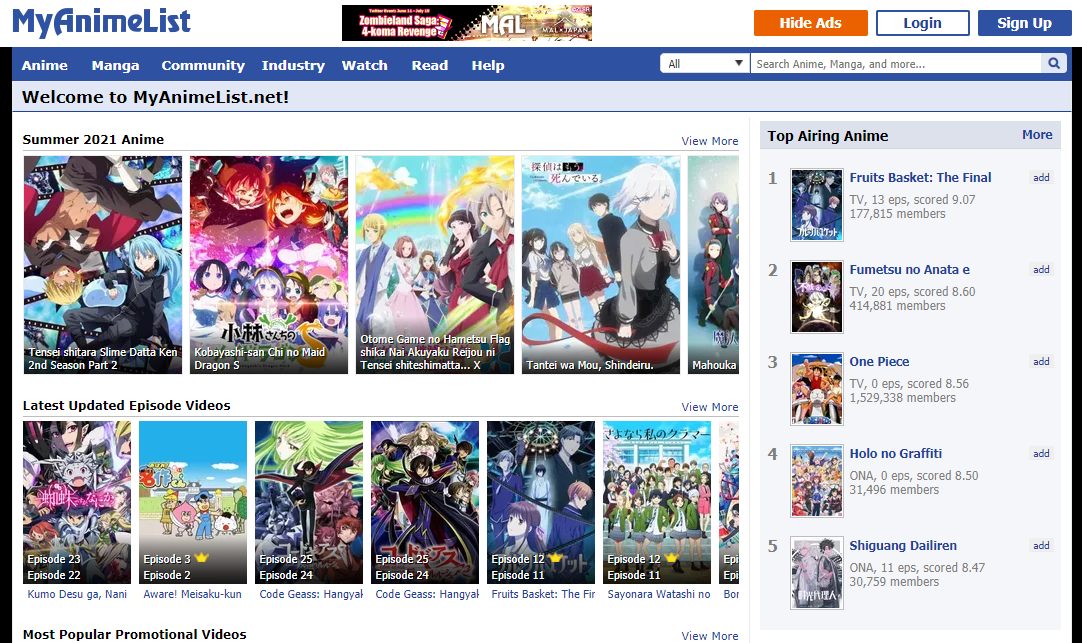

The data used for training Rikonet was crawled from the popular anime website [MyAnimeList.net](http://myanimelist.net/) using the Jikan API. The collected data was cleaned of duplicates as well as missing values and false data and reduced to 6668 anime titles while retaining all the key information.

Following that, autoencoders used to learn embeddings of all the anime titles present in the dataset, which were then used to cluster the same.

The logically opposite clusters of the anime titles are estimated as well.

At run-time, when a user requests a new recommendation list, the user’s context, i.e., the anime titles rated so far is fed into the primary autoencoder, which computes the predicted ratings for the unrated titles.

These ratings are further fed to a hybrid filter, which generates 2 lists, namely - Similar Anime and Anime You May Like, the former showing anime titles similar to the ones the user rated highly and the later showing titles which the user may like based on his overall ratings.

### Setup

In [1]:
!pip install google_trans_new

In [1]:
from collections import OrderedDict
from tabulate import tabulate
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from google_trans_new import google_translator  

### Download data and pre-trained model

In [5]:
!wget https://github.com/sparsh-ai/reco-data/raw/master/anime/anime_cleaned.csv
!wget https://github.com/sparsh-ai/reco-data/raw/master/anime/anime_genres.csv
!wget https://github.com/sparsh-ai/reco-data/raw/master/anime/clusters.csv
!wget https://github.com/sparsh-ai/reco-data/raw/master/anime/inputFormater.csv
!gdown --id 1LV7VHOTqU5WgBYxfRcUeY31dbhcBqyzb
!gdown --id 14x3TgzhFl-XCHjJHtX-mZrtTSkJgIIey

--2021-06-25 19:04:45--  https://github.com/sparsh-ai/reco-data/raw/master/anime/anime_cleaned.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sparsh-ai/reco-data/master/anime/anime_cleaned.csv [following]
--2021-06-25 19:04:45--  https://raw.githubusercontent.com/sparsh-ai/reco-data/master/anime/anime_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6326231 (6.0M) [text/plain]
Saving to: ‘anime_cleaned.csv’

anime_cleaned.csv   100%[===================>]   6.03M  39.1MB/s    in 0.2s    

2021-06-25 19:04:46 (39.1 MB/s) - ‘anime_cleaned.csv’ saved [6326231/6326231]

--2021-06-

In [29]:
def top_animes(genre, ani_genre, all_anime):
    top = []
    print("\nTop", genre)
    temp = list(ani_genre[ani_genre[genre]==1]['anime_id'])
    temp = list(filter(lambda x: x in all_anime.index, temp))
    temp.sort(key=lambda x: all_anime['score'][x], reverse=True)

    for i in range(5):
        r = [i+1, temp[i], all_anime['title'][temp[i]], all_anime['title_english'][temp[i]],
             all_anime['score'][temp[i]], all_anime['genre'][temp[i]]]
        top.append(r)

    table = tabulate(top, headers=['S.No.', 'Anime ID', 'Title', 'English Title',
                                   'Anime Score', 'Anime Genre'], tablefmt='orgtbl')
    print(table)

In [2]:
results = pd.read_csv('clusters.csv')
results.head()

,anime_id,title,alpha,omega,zeta
0,11013,Inu x Boku SS,15,82,135
1,2104,Seto no Hanayome,125,157,55
2,5262,Shugo Chara!! Doki,130,113,82
3,721,Princess Tutu,159,108,97
4,12365,Bakuman. 3rd Season,112,55,29


In [3]:
clusters = []

for i in range(222):
    clusters.append([])

for i in range(len(results)):
    clusters[results['alpha'][i]].append(results['anime_id'][i])

def getCluster(anime_id, opposite=False):
    if opposite == False:
        temp = results[results['anime_id'] == anime_id]['alpha'].reset_index(drop=True)
        clusterID = temp[0]
        return clusters[clusterID]
    else:
        temp = results[results['anime_id'] == anime_id]['zeta'].reset_index(drop=True)
        clusterID = temp[0]
        return clusters[clusterID]

In [4]:
input_formater = pd.read_csv("inputFormater.csv")
input_formater.iloc[:5, :5]

,Gender,Category2,Category3,Category4,Category5


In [5]:
class UserVector(Dataset):
    def __init__(self, age, gender, uratings):
        if age<11:
            self.age=2
        elif age<16:
            self.age=3
        elif age<20:
            self.age=4
        else:
            self.age=5

        if gender.lower() == 'male':
            self.gender = 0
        else:
            self.gender = 1

        self.data = input_formater
        self.data.loc[0, 'Gender'] = self.gender
        self.data.loc[0, 'Category'+str(self.age)] = 1

        self.columns = list(self.data.columns)

        self.aniId_to_ind = pd.Series(data=range(len(self.columns)), index=self.columns)

        for aniId in uratings.keys():
            self.data.loc[0, str(aniId)] = uratings[aniId]
        self.data.fillna(0, inplace=True)

        self.data = self.data.iloc[:,:]

        self.transform =  transforms.Compose([transforms.ToTensor()])

        self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector

    def get_anime_id(self, ind):
        return int(self.columns[ind])

    def anime_to_index(self):
        return self.aniId_to_ind

In [6]:
ani_genre = pd.read_csv("anime_genres.csv", index_col=[0])
ani_genre.head()

,anime_id,Sports,Parody,Mecha,Cars,Dementia,Slice of Life,Mystery,Horror,Super Power,Magic,Demons,Shoujo,Space,Military,Seinen,Action,Music,Vampire,Historical,Game,Harem,Samurai,Sci-Fi,Psychological,Josei,Ecchi,Comedy,Fantasy,School,Yuri,Adventure,Drama,Kids,Hentai,Shounen,Thriller,Romance,Shoujo Ai,Supernatural,Police,Yaoi,Martial Arts,Shounen Ai
0,11013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0
1,2104,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,5262,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,721,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,12365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0


In [7]:
# Get similar anime
def similarAnime(uratings, all_anime):

    if len(uratings) == 0:
        anime_data = all_anime.set_index('anime_id')

        top_animes('Shounen', ani_genre, anime_data)
        top_animes('Supernatural', ani_genre, anime_data)
        top_animes('Romance', ani_genre, anime_data)
        top_animes('Slice of Life', ani_genre, anime_data)

        return []

    else:
        temp = list(reversed(uratings.items()))
        SimilarAnime = []

        i = 0
        while i < len(temp) and i < 3:
            if temp[i][1] >= 6:
                SimilarAnime += getCluster(temp[i][0], opposite=False)
            else:
                SimilarAnime += getCluster(temp[i][0], opposite=True)
            i+=1
        return SimilarAnime

In [8]:
# Get Anime You May Like
def animeYouMayLike(age, gender, uratings, model, all_anime, aniId_to_index):
    # Get Similar Anime
    SimilarAnime = similarAnime(uratings, all_anime)
    if len(SimilarAnime) == 0:
        return [], []
    
    # User Data Column
    user_data = UserVector(age, gender, uratings)

    # User Data Loader
    user_dl = DataLoader(dataset=user_data, num_workers=1)

    # Get model Predictions
    preds = model.getPredictedRatings(user_data, user_dl)
    preds = preds.reshape(-1)

    # Get top predicted anime
    animes = list(preds.argsort()[-1000:][::-1])
    animes = list(map(user_data.get_anime_id, animes))

    # Generate 'Similar Anime' and 'Anime You May Like'
    FinalList1 = []
    FinalList2 = []

    for aniID in animes:
        index = int(aniId_to_index.at[aniID])
        r = [aniID, all_anime['title'][index], all_anime['title_english'][index], all_anime['genre'][index]]

        if aniID in SimilarAnime and len(FinalList1) <10 and aniID not in uratings:
            FinalList1.append(r)
        elif aniID not in SimilarAnime and len(FinalList2) <10 and aniID not in uratings:
            FinalList2.append(r)
        elif len(FinalList1) == 10 and len(FinalList2) == 10:
            break

    return FinalList1, FinalList2

In [9]:
def showRecommendations(age, gender, uratings, model, all_anime, aniId_to_index):
    # Get both the lists
    List1, List2 = animeYouMayLike(age, gender, uratings, model, all_anime, aniId_to_index)
    if len(List1) == 0 and len(List2) == 0:
        return
    
    # Tabulate the Results
    print("similar Anime")
    table = tabulate(List1, headers=['Anime ID', 'JP Title', 'EN Title', 'Genre'], tablefmt='orgtbl')
    print(table)

    print("Anime You May Like")
    table = tabulate(List2, headers=['Anime ID', 'JP Title', 'EN Title', 'Genre'], tablefmt='orgtbl')
    print(table)

### Autoencoder model

In [10]:
def activation(input, type):
  
    if type.lower()=='selu':
        return F.selu(input)
    elif type.lower()=='elu':
        return F.elu(input)
    elif type.lower()=='relu':
        return F.relu(input)
    elif type.lower()=='relu6':
        return F.relu6(input)
    elif type.lower()=='lrelu':
        return F.leaky_relu(input)
    elif type.lower()=='tanh':
        return F.tanh(input)
    elif type.lower()=='sigmoid':
        return F.sigmoid(input)
    elif type.lower()=='swish':
        return F.sigmoid(input)*input
    elif type.lower()=='identity':
        return input
    else:
        raise ValueError("Unknown non-Linearity Type")

In [11]:
class AutoEncoder(nn.Module):

  def __init__(self, layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=True):

    super(AutoEncoder, self).__init__()

    self.layer_sizes = layer_sizes
    self.nl_type = nl_type
    self.is_constrained = is_constrained
    self.dp_drop_prob = dp_drop_prob
    self.last_layer_activations = last_layer_activations

    if dp_drop_prob>0:
      self.drop = nn.Dropout(dp_drop_prob)

    self._last = len(layer_sizes) - 2

    # Initaialize Weights
    self.encoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes) - 1)  ] )

    # "Xavier Initialization" ( Understanding the Difficulty in training deep feed forward neural networks - by Glorot, X. & Bengio, Y. )
    # ( Values are sampled from uniform distribution )
    for weights in self.encoder_weights:
      init.xavier_uniform_(weights)

    # Encoder Bias
    self.encoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(layer_sizes[i+1])) for i in range(len(layer_sizes) - 1) ] )

    reverse_layer_sizes = list(reversed(layer_sizes)) 
    # reversed returns iterator

    # Decoder Weights
    if is_constrained == False:
      self.decoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(reverse_layer_sizes[i+1], reverse_layer_sizes[i])) for i in range(len(reverse_layer_sizes) - 1) ] )

      for weights in self.decoder_weights:
        init.xavier_uniform_(weights)

    self.decoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(reverse_layer_sizes[i+1])) for i in range(len(reverse_layer_sizes) - 1) ] )



  def encode(self,x):
    for i,w in enumerate(self.encoder_weights):
      x = F.linear(input=x, weight = w, bias = self.encoder_bias[i] )
      x = activation(input=x, type=self.nl_type)

    # Apply Dropout on the last layer
    if self.dp_drop_prob > 0:
      x = self.drop(x)

    return x


  def decode(self,x):
    if self.is_constrained == True:
      # Weights are tied
      for i,w in zip(range(len(self.encoder_weights)),list(reversed(self.encoder_weights))):
        x = F.linear(input=x, weight=w.t(), bias = self.decoder_bias[i] )
        x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'relu')

    else:

      for i,w in enumerate(self.decoder_weights):
        x = F.linear(input=x, weight = w, bias = self.decoder_weights[i])
        x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'relu')

    return x

  def forward(self,x):
    # Forward Pass
    return self.decode(self.encode(x))

In [12]:
class PredictionEngine:
  def __init__(self):
    self.layer_sizes = [6673, 8192, 2048, 512, 256]
    self.model = AutoEncoder(layer_sizes=self.layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=False)
    self.model.load_state_dict(torch.load('autoEncoder.pth'))
    try:
        self.model = self.model.cuda()
    except:
        pass

  def getPredictedRatings(self, user_dat, user_dl):
    for data in user_dl:
      inputs = data
      try:
          inputs = inputs.cuda()
      except:
          pass
      inputs = inputs.float()

      outputs = self.model(inputs)
      break

    return outputs.cpu().detach().numpy()

In [13]:
# Search anime in database
def find_anime(input_anime, name_to_id):
    print('Anime Id', '\t', 'Title')
    flag = 0
    for n in name_to_id.index:
        if input_anime in n.lower():
            flag = 1
            print(name_to_id[n], '\t', n)
    return flag

### Load cleaned dataset

In [14]:
# Load all the datasets
all_anime = pd.read_csv("anime_cleaned.csv")
display(all_anime.head())

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,"Aug 16, 2002 to May 23, 2003","{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,"Oct 6, 2012 to Mar 30, 2013","{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [4]:
all_anime.image_url[0]

'https://myanimelist.cdn-dena.com/images/anime/12/35893.jpg'

In [17]:
from PIL import Image
import requests
from io import BytesIO

def id_to_image(anime_id):
  url = all_anime.loc[all_anime['anime_id']==anime_id, 'image_url'].values[0]
  url = url.split('/')
  url = ['https://cdn.myanimelist.net'] + url[3:]
  url = '/'.join(url)
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  return img

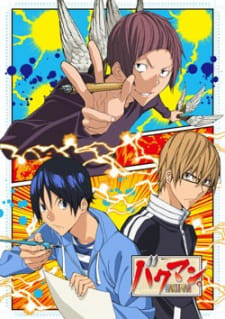

In [18]:
id_to_image(12365)

### Japanese to english translated titles

In [46]:
all_anime_small = all_anime.sample(200, random_state=42)
translator = google_translator()
all_anime_small['title_english_new'] = all_anime_small.apply(lambda row: translator.translate(row.title_japanese), axis=1)
all_anime_small.title_english_new.unique()

array(['<Harmony /> Harmony ',
       'Pocket Monster Diamond & Pearl Dialga VS Parcia VS Dur Cry ',
       'Tokiwa coming! ',
       'Crayon Shin-chan Cho ~ Hero of the Cold Call Calling a Storm ',
       'Aim for the top! & Top 2! Combine Movie version !! ',
       'Great Teacher Onida ', 'White album ', 'Fruit 5 sisters ',
       'Love, Chunibyo & Other Delusions! Depth of Field ~ Love and Hatred Theater ',
       'Manipulate Dreamnote ',
       "Dragon Ball Genie Castle's Sleeve Princess ", 'Angel cup ',
       'Attack on Titan Omnibus "From that day" ', 'Fire bird 鳳 編 編 ',
       "Pikachu's sparkling! ", 'Eye Shield 21 Phantom Golden Bowl ',
       'Giant God Gogue <Giant Gogg> ', 'My wife is a magic girl ',
       'Sengoku Musou SP Sanada chapter ',
       'Wolf Fafner Right of Left ~ Single Program ~ ',
       'ef - a tale of memories. ~prologue~ ',
       'Galactic Hero Legend: My Conqueries of the Stars ',
       'Yuuki Yuki is a brave ', 'I enjoyed the firefly ',
       'OKAW

In [16]:
name_to_id = pd.Series(list(all_anime['anime_id']), index=all_anime['title'])
aniId_to_index = pd.Series(all_anime.index, index=all_anime['anime_id'])

### Run time process

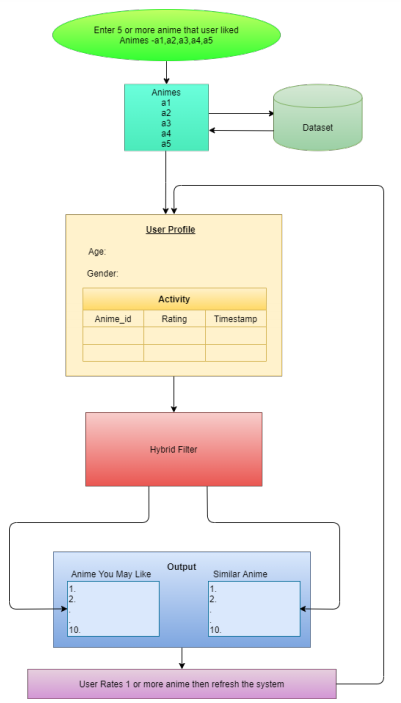

### Hybrid filter

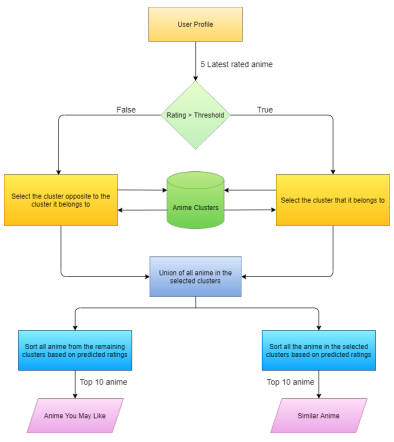

### Run time

In [17]:
print("Starting...\n")

# Load the AutoEncoder
model = PredictionEngine()

# Get basic information from the user
age = int(input("Enter Age: "))
gender = input("Enter Gender (Male/Female): ")
input_ratings = OrderedDict()

# Let the user rate some animes
print("\nIt is recommended to rate atleast 5 animes in the beginning.")
print("Note:- Currently search mechanism searches for anime using the Japanese Title only.")

# List for storing the user ratings of recommended table
user_score = []
c = 1

# Start the recommendation process
k1 = input("\nStart the process? [y/n]: ")

while k1 == 'y' or k1 == 'Y':

    # If user want to search and rate
    k2 = input("\nSearch and rate? [y/n]: ")
    while k2 == 'y' or k2 == 'Y':
        p = 'n'
        while p == 'n' or p == 'N':
            input_anime = input("Enter Anime title: ")
            flag = find_anime(input_anime.lower(), name_to_id)
            if flag==0:
                print("\nAnime not found in dataset. Please try searching only a part of the title or another anime!!")
                continue
            p = input("Anime found? [y/n]: ")

        aniId = int(input("Enter anime id: "))
        rate = int(input("Your rating (1 - 10): "))
        if not type(rate) is int:
              raise TypeError("Only integers are allowed")
              
        input_ratings[aniId] = rate

        k2 = input("Search and rate more? [y/n]: ")

    # Main Game
    showRecommendations(age, gender, input_ratings, model, all_anime, aniId_to_index)

    # If user want to rate anime from above list
    k2 = input("\nRate anime from above list? [y/n]:")
    while k2 == 'y' or k2 == 'Y':
        aniId = int(input("Enter anime id: "))
        rate = int(input("Your rating (1 - 10): "))
        input_ratings[aniId] = rate

        k2 = input("Rate again from above list? [y/n]: ")

    k2 = int(input("Your score for the table of recommended anime (1 - 10):"))
    user_score.append([c, k2])
    c += 1
    
    k1 = input("\nKeep going? [y/n]: ")

# Displaying the user score over iterations
print('\n\nTable of user scores')
table = tabulate(user_score, headers=['Iterations', 'User Score'], tablefmt='grid')
print(table)

Starting...

Enter Age: 25
Enter Gender (Male/Female): Male

It is recommended to rate atleast 5 animes in the beginning.
Note:- Currently search mechanism searches for anime using the Japanese Title only.

Start the process? [y/n]: y

Search and rate? [y/n]: y
Enter Anime title: magic
Anime Id 	 Title
33358 	 Mahou no Star Magical Emi: Finale! Finale!
23831 	 Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari - Magica Quartet x Nisioisin
2038 	 Mahou no Star Magical Emi
30030 	 Jewelpet Magical Change
5080 	 Quiz Magic Academy: The Original Animation
4017 	 Magical Moe
36760 	 Detective Conan: The Magician of Starlight
8443 	 Mahou no Star Magical Emi: Semishigure
941 	 Renkin San-kyuu Magical? Pokaan
34104 	 Knight&#039;s & Magic
1367 	 Detective Conan Movie 08: Magician of the Silver Sky
17725 	 Magical☆Star Kanon 100%
11979 	 Mahou Shoujo Madoka★Magica Movie 2: Eien no Monogatari
11981 	 Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari
8310 	 Magic Kaito
1563 	 Ma

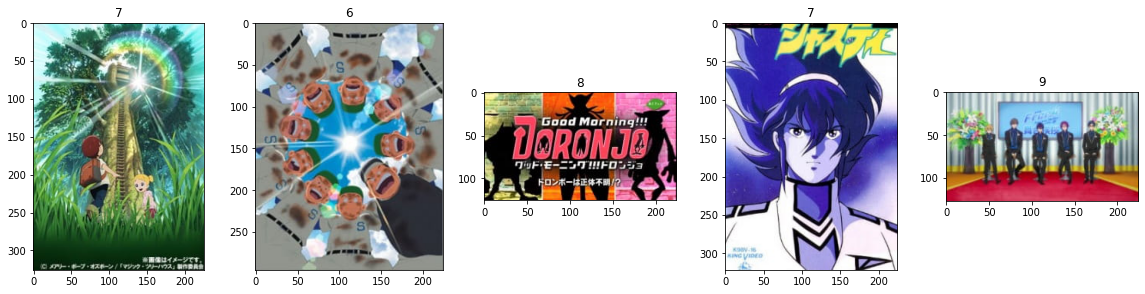

In [26]:
rated_anime = [10690, 3768, 31699, 2056, 37858]
ratings = [7, 6, 8, 7, 9]
rated_anime_images = [id_to_image(id) for id in rated_anime]
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(rated_anime_images):
    plt.subplot(len(rated_anime_images) / columns + 1, columns, i + 1)
    plt.gca().set_title(ratings[i])
    plt.imshow(image)

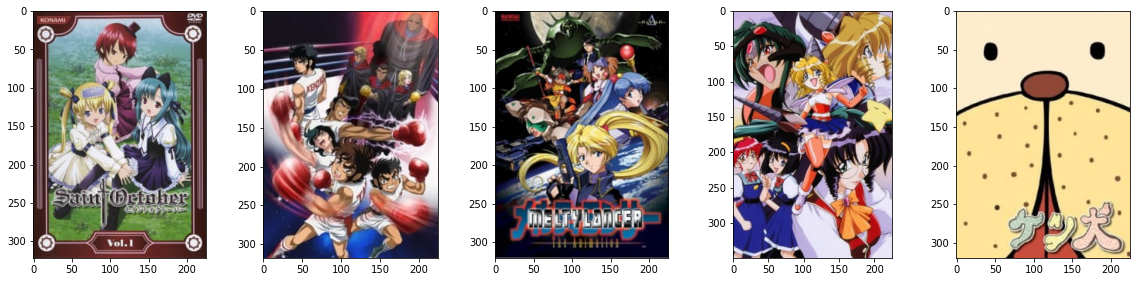

In [22]:
similar_anime = [1724, 1771, 1155, 2723, 8353]
similar_anime_images = [id_to_image(id) for id in similar_anime]
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(similar_anime_images):
    plt.subplot(len(similar_anime_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

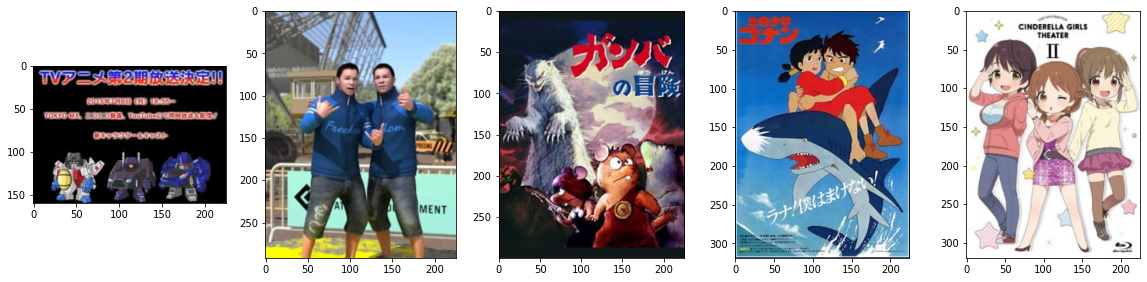

In [24]:
personalized_anime = [30851, 33473, 5267, 7308, 35805]
personalized_anime_images = [id_to_image(id) for id in personalized_anime]
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(personalized_anime_images):
    plt.subplot(len(personalized_anime_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### References
1. Paper: [https://arxiv.org/pdf/2106.12970.pdf](https://arxiv.org/pdf/2106.12970.pdf)
2. Code: [https://github.com/NilutpalNath/RikoNet](https://github.com/NilutpalNath/RikoNet)